In [1]:
import os
import sys

import warnings
warnings.filterwarnings("ignore")

import torch
import torchvision
import torchaudio

import numpy as np
import pandas as pd
import librosa
import PIL
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from IPython.display import display, Markdown

import scripts.generate_dual_resonance as generation_script

In [6]:
import shared.utils as su

In [7]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/SyntheticPouring/v9.0"
!ls $data_dir/splits/

train.txt  valid.txt


In [9]:
train_ids = su.io.load_txt(os.path.join(data_dir, "splits/train.txt"))
len(train_ids)

5569

In [10]:
valid_ids = su.io.load_txt(os.path.join(data_dir, "splits/valid.txt"))
len(valid_ids)

1461

In [11]:
df = pd.read_csv(os.path.join(data_dir, "metadata/combined.csv"))
df.shape

(7030, 11)

In [17]:
df_train = df[df.id.isin(train_ids)]
df_valid = df[df.id.isin(valid_ids)]
df.columns

Index(['item_id', 'source_audio_path', 'duration', 'height', 'radius', 'beta',
       'b', 'container_shape', 'Hn', 'Rn', 'id'],
      dtype='object')

In [19]:
df_train.container_shape.value_counts()

container_shape
bottleneck     2794
cylindrical    2775
Name: count, dtype: int64

In [20]:
df_valid.container_shape.value_counts()

container_shape
cylindrical    779
bottleneck     682
Name: count, dtype: int64

In [24]:
audio_dir = os.path.join(data_dir, "wav")

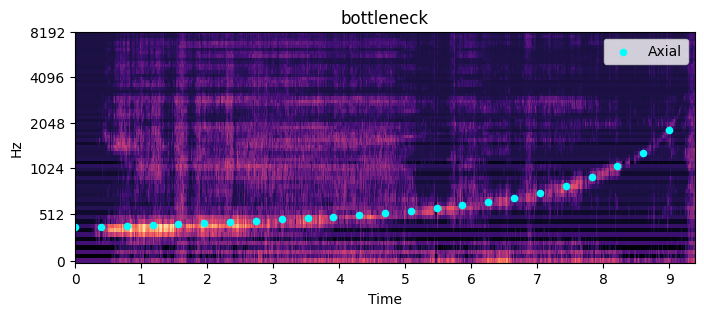

In [156]:
# Analyse some sample train/validation set

df_show = df_train
i = np.random.randint(len(df_show))

row = df_show.iloc[i].to_dict()
path = os.path.join(audio_dir, row["id"] + ".wav")
sr = 16000
y = su.audio.load_audio_torchaudio(path, sample_rate=sr)
S = su.audio.librosa_harmonic_spectrogram_db(y, sr=sr, margin=8.)

# Show frequency annotations
n_eval = 25
t = np.linspace(0, row["duration"] - 0.001, n_eval)
f_axial = su.physics.get_frequencies(
    t, row, harmonic=None, vibration_type="axial", container_shape=row["container_shape"], 
)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
su.audio.show_logmelspectrogram(
    S, sr=sr, title=row["container_shape"], ax=ax, show=False, 
)
F_MAX = 8000
indices = np.where((f_axial < F_MAX))
ax.scatter(
    t[indices], f_axial[indices], color="cyan", s=20, label="Axial",
)
ax.legend()
plt.show()

**Get min/max values**

In [133]:
iterator = su.log.tqdm_iterator(
    range(len(df))
)
F = []
for i in iterator:
    row = df.iloc[i].to_dict()
    t = np.array([0.])
    f_axial = su.physics.get_frequencies(
        t, row, harmonic=None, vibration_type="axial", container_shape=row["container_shape"], 
    )
    F.append(f_axial)
F = np.stack(F)
F.shape

  0%|          | 0/7030 [00:00<?, ?it/s]

(7030, 1)

In [88]:
C = 340 * 100

C/ F.min(), C / F.max()

(558.9621163215636, 17.021746908920683)

In [95]:
W = C / F
(W > 500).sum()

4